# Flopy example 1
building basic modflow6 model from scratch using flopy, constant boundaries & pump

In [1]:
import flopy
import numpy as np

flopy is installed in C:\thomas\Anaconda3\lib\site-packages\flopy


In [2]:
# set up model
modelname = 'ex1'
sim = flopy.mf6.MFSimulation(sim_name='ex1', version='mf6', exe_name='mf6', sim_ws='sim/ex1')
mf = flopy.mf6.ModflowGwf(sim, modelname=modelname)

# create discretization object, time, 1 steady state period of 1 day
tdis = flopy.mf6.ModflowTdis(sim, time_units='days', perioddata=[(1000.0,10,1.0)]) # periode len, period steps, period multiplier

In [3]:
# model domain & grid definition
Lx, Ly = 1000., 1000. # aquifer length in x, y [meters]
ztop, zbot = 0., -50. # aquifer top/bottom elevation
nlay, nrow, ncol = 1, 50, 50 # # of layer, rows, columns
delr, delc = Lx/ncol, Ly/nrow # spacing along rows/columns
delv = (ztop - zbot) / nlay # spacing along depth
botm = np.linspace(ztop, zbot, nlay+1) # bottom elevation

# create discretization object, spatial
dis = flopy.mf6.ModflowGwfdis(mf, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, top=ztop, botm=botm[1:], length_units='METERS')

In [4]:
# define initial heads for model to 20
ic = flopy.mf6.ModflowGwfic(mf, strt=1)

# set constant head, first & last column have constant head of 20 the 'river'
heads = [[(0, row, 0), 10] for row in range(nrow)] # set constant head of 10 at first column
heads.extend([[(0, row, ncol-1), 1] for row in range(nrow)]) # set constant head of 1 at last column 
chd = flopy.mf6.ModflowGwfchd(mf, stress_period_data=heads)

In [5]:
# define hydraulic properties
npf = flopy.mf6.ModflowGwfnpf(mf, save_flows=True, icelltype=1, k=10., k33=10., save_specific_discharge=True) # hydraulic conductivity horizontal (k) / vertical (k33)

In [6]:
# add well
pumping_rate = -1000. # m3/day
wrow = int(ncol/2 - 1) # middle row
wcol = int(nrow/2 - 1) # middle column
spd = [[(0, wrow, wcol), pumping_rate]] # in first layer, 0-layer
wel = flopy.mf6.ModflowGwfwel(mf, stress_period_data=spd)

In [7]:
# output control, use defaults
saverecord = [('HEAD', 'ALL'), 
              ('BUDGET', 'ALL')]
printrecord = [('HEAD', 'LAST')]
headfile = ['{}.hds'.format(modelname)]
budgetfile = ['{}.cbc'.format(modelname)]
oc = flopy.mf6.ModflowGwfoc(mf, saverecord=saverecord, printrecord=printrecord, head_filerecord=headfile, budget_filerecord=budgetfile)

In [8]:
# create the flopy iterative model solver (ims) package object
ims = flopy.mf6.modflow.mfims.ModflowIms(sim)

In [9]:
# write & run simulation
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model ex1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 100 based on size of stress_period_data
    writing package npf...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: C:\thomas\modflow\mf6.1.0\bin\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.1.0 12/12/2019

   MODFLOW 6 compiled Dec 12 2019 13:30:12 with IFORT compiler (ver. 19.0.5)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has 

(True, [])

In [10]:
keys = sim.simulation_data.mfdata.output_keys()

('ex1', 'CBC', 'FLOW-JA-FACE')
('ex1', 'CBC', 'DATA-SPDIS')
('ex1', 'HDS', 'HEAD')


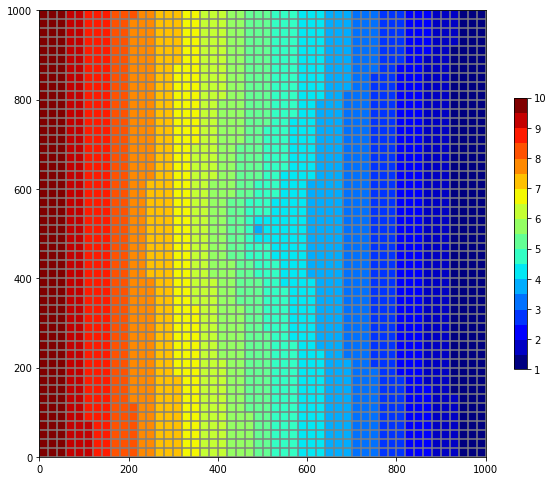

In [11]:
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1,aspect='equal')

# get head data
head = sim.simulation_data.mfdata['ex1', 'HDS', 'HEAD']
head = head[-1]

modelmap = flopy.plot.PlotMapView(model=mf, layer=0)
linecollection = modelmap.plot_grid()
cs = modelmap.plot_array(head, cmap=plt.get_cmap('jet', 18))

plt.colorbar(cs, shrink=0.5)
plt.show()